In [1]:
import os,sys, re, time
from importlib import reload
import numpy as np
import pandas as pd

#import torch
print(os.getpid())
sys.path.append(r'C:\Softwares\Github\MerScope01')

71084


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [5]:
# data_folder
data_folder = r'\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s'
# correction
correction_folder = r'\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\Corrections\20210621-STORM6_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [6]:
# transpose with microscope
microscope_file = r'\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\Softwares\Weissman_MERFISH_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [7]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = r'\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Analysis\Color_Usage.csv'
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s
-- 20 folders, 173 fovs detected.
- load color_usage from file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Analysis\Color_Usage.csv


In [8]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '647', 'hyb': 'H19R1'} 488


# Run segmentation

In [9]:

from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d

In [10]:

for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=60, 
                                        min_size=2000,
                                        do_3D=True,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = labels3d.copy() # no modification is required for this one.

        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )

Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_1.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_2.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_3.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_4.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_l

Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_107.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_108.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_109.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_110.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_111.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segm

- apply microscope corrections
- run Cellpose segmentation in 142.370s.
- save to file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_20.npy


<IPython.core.display.Javascript object>


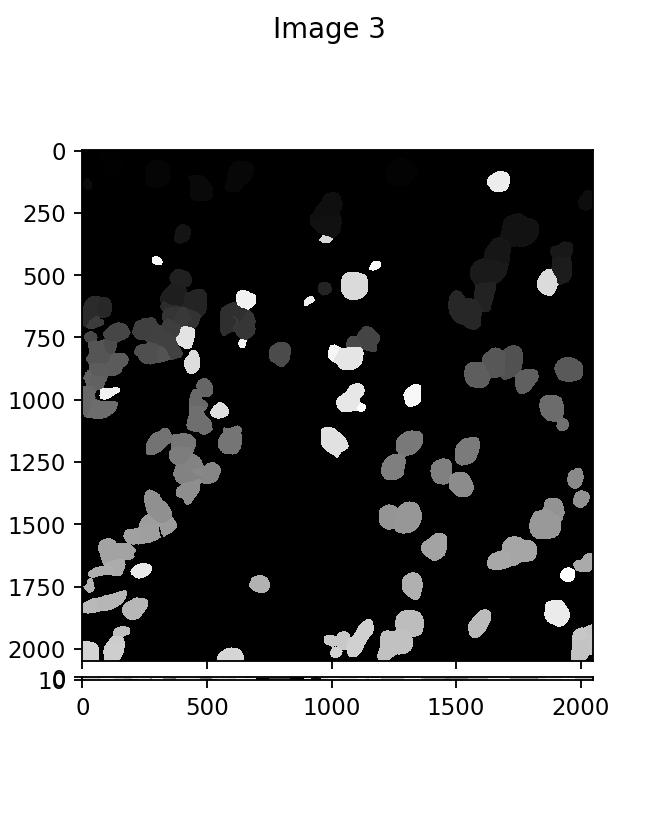

In [24]:
%matplotlib notebook
imshow_mark_3d([polyt_im, dapi_im, corr_labels3d])

# STEP2: Watershed: Optional, potentially make it worse

In [11]:
watershed_th = 1.6

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    #np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    break

- directly load seg from: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy
reference image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
PolyT and DAPI image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H19R1\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
- New save file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488', '405'] in 1.732s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:[

<IPython.core.display.Javascript object>


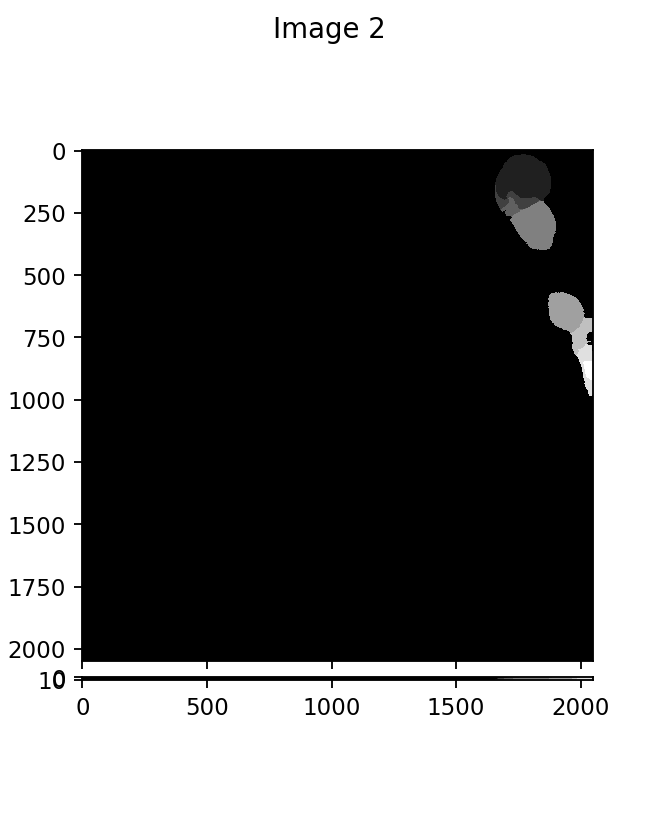

In [203]:
imshow_mark_3d([new_labels, corr_labels3d])

## load images and drifts

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')

In [13]:
np.load(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4_merlin_env\FiducialCorrelationWarp\transformations\offsets_30.npy', allow_pickle=True)

array([<SimilarityTransform(matrix=
           [[ 1., -0., -0.],
            [ 0.,  1., -0.],
            [ 0.,  0.,  1.]]) at 0x1e7a1a807f0>,
       <SimilarityTransform(matrix=
           [[ 1., -0., -0.],
            [ 0.,  1., -0.],
            [ 0.,  0.,  1.]]) at 0x1e7a1a808e0>,
       <SimilarityTransform(matrix=
           [[ 1.  , -0.  ,  3.01],
            [ 0.  ,  1.  , 10.07],
            [ 0.  ,  0.  ,  1.  ]]) at 0x1e7a1a80940>,
       <SimilarityTransform(matrix=
           [[ 1.  , -0.  ,  3.01],
            [ 0.  ,  1.  , 10.07],
            [ 0.  ,  0.  ,  1.  ]]) at 0x1e7a1a80850>,
       <SimilarityTransform(matrix=
           [[ 1.  , -0.  ,  2.33],
            [ 0.  ,  1.  ,  7.38],
            [ 0.  ,  0.  ,  1.  ]]) at 0x1e7a1a80970>,
       <SimilarityTransform(matrix=
           [[ 1.  , -0.  ,  2.33],
            [ 0.  ,  1.  ,  7.38],
            [ 0.  ,  0.  ,  1.  ]]) at 0x1e7a1a80e50>,
       <SimilarityTransform(matrix=
           [[ 1.  , -0.  , 14.07],

In [81]:
np.load(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\transformations\offsets_30.npy', allow_pickle=True)

array([[[  1.  ,  -0.  ,  -0.  ],
        [  0.  ,   1.  ,  -0.  ],
        [  0.  ,   0.  ,   1.  ]],

       [[  1.  ,  -0.  ,  -0.  ],
        [  0.  ,   1.  ,  -0.  ],
        [  0.  ,   0.  ,   1.  ]],

       [[  1.  ,  -0.  ,   3.01],
        [  0.  ,   1.  ,  10.07],
        [  0.  ,   0.  ,   1.  ]],

       [[  1.  ,  -0.  ,   3.01],
        [  0.  ,   1.  ,  10.07],
        [  0.  ,   0.  ,   1.  ]],

       [[  1.  ,  -0.  ,   2.33],
        [  0.  ,   1.  ,   7.38],
        [  0.  ,   0.  ,   1.  ]],

       [[  1.  ,  -0.  ,   2.33],
        [  0.  ,   1.  ,   7.38],
        [  0.  ,   0.  ,   1.  ]],

       [[  1.  ,  -0.  ,  14.07],
        [  0.  ,   1.  ,   9.57],
        [  0.  ,   0.  ,   1.  ]],

       [[  1.  ,  -0.  ,  14.07],
        [  0.  ,   1.  ,   9.57],
        [  0.  ,   0.  ,   1.  ]],

       [[  1.  ,  -0.  ,  14.01],
        [  0.  ,   1.  ,   6.83],
        [  0.  ,   0.  ,   1.  ]],

       [[  1.  ,  -0.  ,  14.01],
        [  0.  ,   1.  ,   6.8

In [79]:
from skimage.registration import phase_cross_correlation
from skimage.transform import SimilarityTransform, EuclideanTransform

In [16]:
offsets = [phase_cross_correlation(ims[0], im, upsample_factor=10)[0] for im in ims[2:5] ]

In [17]:
offsets

[array([0., 0.]), array([0., 0.]), array([0., 0.])]

In [21]:
np.unique(ims[0] - ims[2])

array([    0,     1,     2, ..., 65533, 65534, 65535], dtype=uint16)

In [170]:
from merlin.util.imagereader import DaxReader
from merlin.util.dataportal import DataPortal, FilePortal


In [167]:
test = FilePortal(fileName=ref_image_file)

TypeError: Can't instantiate abstract class FilePortal with abstract methods close, exists, get_sibling_with_extension, read_as_text, read_file_bytes

In [177]:
test_im = DaxReader(DataPortal.create_portal(ref_image_file).open_file(ref_image_file)).load_frame(34)

<IPython.core.display.Javascript object>


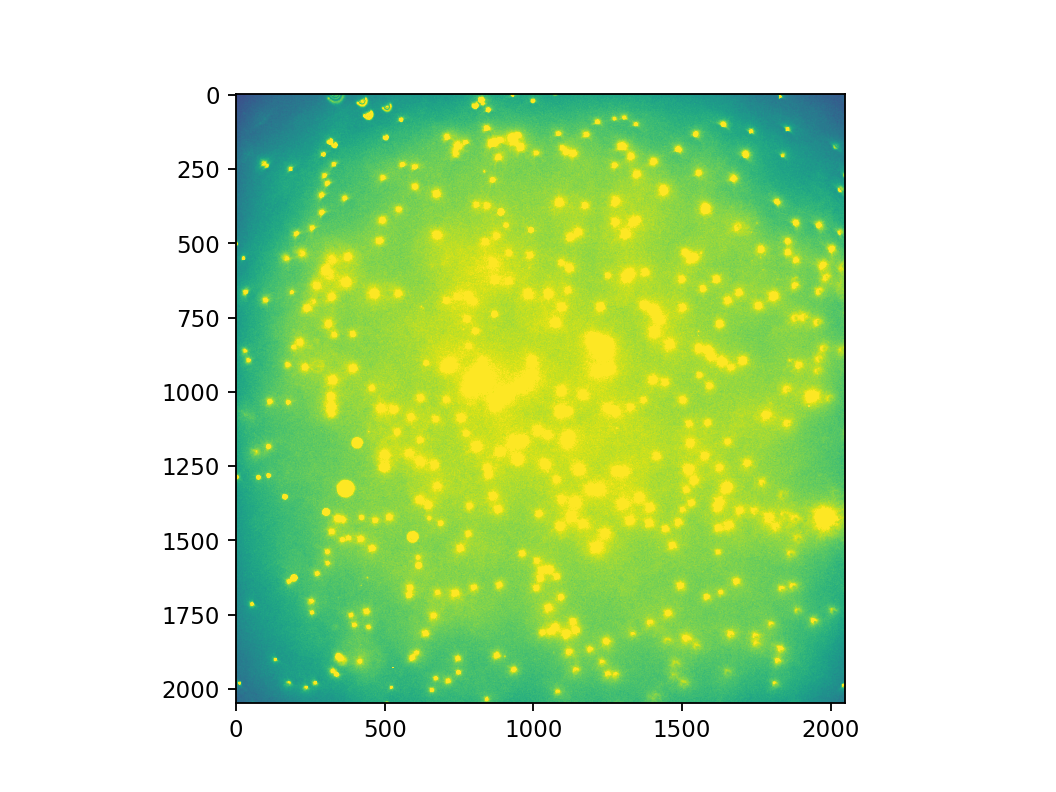

In [183]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(ims[0], vmin=200, vmax=900)

<IPython.core.display.Javascript object>


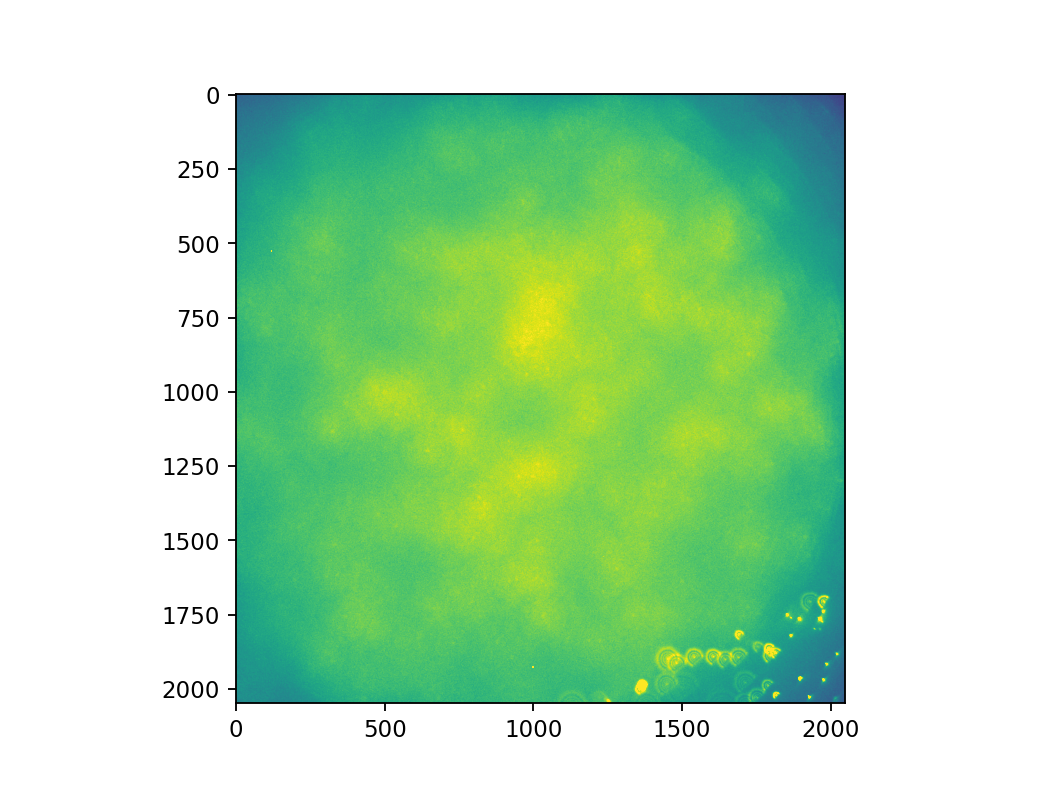

In [182]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(test_im, vmin=200, vmax=900)

In [65]:
_ref_cls.im_488[8]

array([[145, 216,  92, ..., 121, 101, 130],
       [154, 190, 225, ..., 117, 128, 104],
       [225, 224, 175, ..., 177, 137, 146],
       ...,
       [233, 301, 388, ..., 188, 136, 167],
       [401, 198, 322, ..., 249, 145, 140],
       [295, 220, 274, ..., 168, 201, 175]], dtype=uint16)

In [33]:
highPassSigma = 2
highPassFilterSize = int(2 * np.ceil(2 * highPassSigma) + 1)
highPassFilterSize

9

In [53]:
ref_im = ims[0]
ft_ref_im = ref_im.astype(np.float32) - cv2.GaussianBlur(ref_im, 
                                                    (highPassFilterSize, highPassFilterSize),
                                                    highPassSigma, borderType=cv2.BORDER_REPLICATE)
ft_ref_im[ft_ref_im< 0] = 0

In [63]:
test_im = ims[4]
ft_test_im = test_im.astype(np.float32) - cv2.GaussianBlur(test_im, 
                                                    (highPassFilterSize, highPassFilterSize),
                                                    highPassSigma, borderType=cv2.BORDER_REPLICATE)
ft_test_im[ft_test_im< 0] = 0

In [69]:
phase_cross_correlation(ref_im, test_im, upsample_factor=100, normalization=None)

(array([-7.38, -2.33]), 0.12067566043522124, -2.360699751955922e-07)

In [68]:
phase_cross_correlation(ft_ref_im, ft_test_im, upsample_factor=100, normalization=None)

(array([-7.38, -2.33], dtype=float32), 0.580384606979622, -8.375915e-06)

In [80]:
EuclideanTransform(np.array(SimilarityTransform(translation=[0,0])))

<EuclideanTransform(matrix=
    [[ 1., -0.,  0.],
     [ 0.,  1.,  0.],
     [ 0.,  0.,  1.]]) at 0x1e7a1a30b20>

In [74]:
np.save('test_im.npy', [SimilarityTransform(translation=[0,0])], allow_pickle=True)

C:\Users\puzheng\.conda\envs\postanalysis\lib\site-packages\numpy\lib\npyio.py:521: FutureWarning: The input object of type 'SimilarityTransform' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'SimilarityTransform', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)


TypeError: float() argument must be a string or a real number, not 'SimilarityTransform'

In [72]:
np.load('test_im.npy')

array([[[ 0.,  8.,  7., ..., 17.,  0.,  0.],
        [28., 16., 10., ..., 41., 37.,  0.],
        [21., 16., 23., ...,  0.,  0.,  0.],
        ...,
        [ 0., 11., 35., ..., 12.,  0., 40.],
        [ 0., 37., 21., ..., 47.,  0.,  2.],
        [ 0., 36.,  0., ..., 40.,  0.,  0.]]], dtype=float32)

In [43]:
! conda list scikit-image


# packages in environment at C:\Users\puzheng\.conda\envs\postanalysis:
#
# Name                    Version                   Build  Channel
scikit-image              0.20.0                   pypi_0    pypi


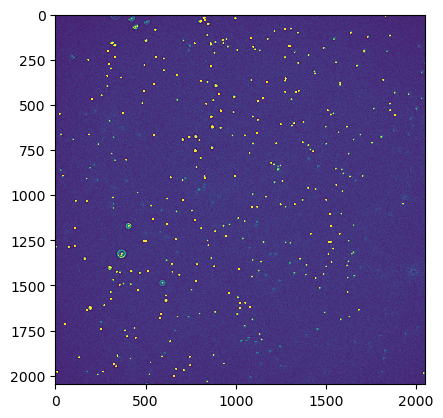

In [66]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(ft_ref_im, vmin=0, vmax=100)

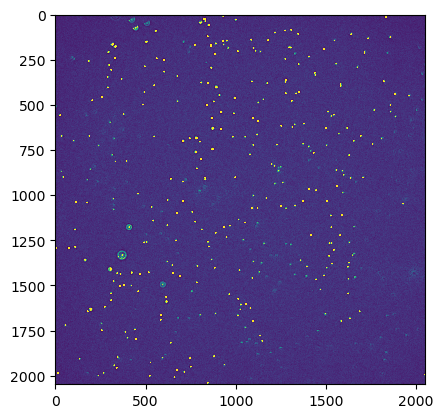

In [67]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(ft_test_im , vmin=0, vmax=100)

In [54]:
offsets

[array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.])]